### SVM classifier trained on images (real and generated ones from 4 generators) from ELSA compressed in jpg with quality 40 and coming. The classifier is tested on images from synthbuster

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import sys
sys.path.append("../tools")
from utils import load_data_features, load_synthbuster_balanced, map_synthbuster_classes
from sklearn.svm import LinearSVC
from datasets import load_from_disk
import open_clip
from IPython.display import clear_output
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K',device="cuda")

model.eval()
clear_output()

In [4]:
def label_conversion(e):
    e["label"] = 1 if e["label"] == "real" else 0
    return e

In [5]:
X_sb, y_sb = load_synthbuster_balanced("../../data/synthbuster_test",
                                       balance_real_fake=True,
                                       binary_classification=True)

In [6]:
X_40, y_40 = load_data_features("../../data/big_QF_40_features","train")
X_h, y_h = load_data_features("../../data/holistic","train")

### Train on big_QF_40_features (1 generator) / Test on holistic (4 generators)

In [7]:
clf = LinearSVC(dual="auto")
clf.fit(X_40,y_40).score(X_h,y_h)

0.641

### Train on holistic (4 generators) / Test on big_QF_40_features (1 generator)

In [8]:
clf = LinearSVC(dual="auto")
clf.fit(X_h,y_h).score(X_40,y_40)

0.9426

### Train on holistic (4 generators) / Test on synthbuster

In [9]:
clf.fit(X_h,y_h).score(X_sb,y_sb)

0.6444199116820554

### Train on synthbuster (9 generators) / Test on holistic (4 generators)

In [10]:
clf.fit(X_sb, y_sb).score(X_h,y_h)

0.6202

### Train and test on synthbuster

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_sb,y_sb,shuffle=True,test_size=.2)
print(X_train.shape)
clf.fit(X_train,y_train).score(X_test,y_test)

(7971, 768)


0.9839438033115906

### Train and test on big_QF_40 (1 generator)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_40,y_40,shuffle=True,test_size=.2)

clf.fit(X_train,y_train).score(X_test,y_test)

0.981

# Train on concatenation of synthbuster + holistic and test on holistic

## train on synthbuster + holistic

In [13]:
X_sb_train, X_sb_test, y_sb_train, y_sb_test = train_test_split(X_sb, y_sb,test_size=.2,shuffle=True,random_state=7)
X_h_train, y_h_train = load_data_features("../../data/holistic",split="train")
X_h_test, y_h_test = load_data_features("../../data/holistic/",split="test")

X_train = np.vstack((X_sb_train,X_h_train))
y_train = np.hstack((y_sb_train,y_h_train))

clf.fit(X_train,y_train)

LinearSVC(dual='auto')

## test on holistic

In [14]:
clf.score(X_h_test,y_h_test)

0.9508

## test on synthbuster

In [15]:
clf.score(X_sb_test,y_sb_test)

0.9668840943301555

## test on big_QF_40

In [16]:
X_40_test, y_40_test = load_data_features("../../data/big_QF_40_features",split="test")
clf.score(X_40,y_40)

0.9449

# Multi class classifier

## uniform distribution of data across all classes

In [17]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo = OneVsOneClassifier(LinearSVC(dual="auto"))
ovr = OneVsRestClassifier(LinearSVC(dual="auto"))
X_sb, y_sb = load_synthbuster_balanced("../../data/synthbuster_test",
                                       binary_classification=False,
                                       balance_real_fake=False)

In [18]:
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X_sb, 
                                                    y_sb,
                                                    test_size=.2,
                                                    shuffle=True,
                                                    random_state=7)
display(Counter(y_sb))
display(Counter(y_test))

Counter({1: 1000,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 1000,
         7: 1000,
         8: 1000,
         9: 1000,
         0: 1000})

Counter({4: 220,
         9: 215,
         8: 209,
         5: 206,
         3: 205,
         6: 200,
         2: 192,
         7: 189,
         0: 183,
         1: 181})

1000 points per classes

In [19]:
ovo.fit(X_train,y_train).score(X_test, y_test)

0.802

In [20]:
ovr.fit(X_train, y_train).score(X_test,y_test)

0.793

## 50% real images and 50% generated (9 generators)

In [30]:
X_sb, y_sb = load_synthbuster_balanced("../../data/synthbuster_test",
                                       binary_classification=False,
                                       balance_real_fake=True)

X_train, X_test2, y_train, y_test2 = train_test_split(X_sb,
                                          y_sb,
                                          shuffle=True,
                                          random_state=7,
                                          test_size=.2)

X_train_filtered = np.zeros_like(X_train)
y_train_filtered = np.zeros_like(y_train)
k = 0
for i, x in enumerate(X_train):
    if x not in X_test:
        X_train_filtered[k] = X_train[i]
        y_train_filtered[k] = y_train[i]
        k += 1
X_train_filtered = X_train_filtered[:k]
y_train_filtered = y_train_filtered[:k]

for x in X_train_filtered:
    if x in X_test:
        print("PROBLEM: SOME POINT ARE SHARED BETWEEN TRAIN AND TEST")
Counter(y_train_filtered)

Counter({0: 3730,
         2: 369,
         1: 368,
         9: 355,
         7: 347,
         3: 347,
         8: 338,
         6: 336,
         4: 334,
         5: 330})

In [22]:
Counter(y_test)

Counter({4: 220,
         9: 215,
         8: 209,
         5: 206,
         3: 205,
         6: 200,
         2: 192,
         7: 189,
         0: 183,
         1: 181})

In [32]:
ovo.fit(X_train_filtered,y_train_filtered).score(X_test,y_test)

/home/lsaland/micromamba/envs/clip/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7855

In [24]:
ovr.fit(X_train_filtered,y_train_filtered).score(X_test,y_test)

0.7465

## Binary classification with multiclass classifier

In [34]:
y_test_hat_ovo = ovo.predict(X_test2)
result = np.zeros_like(y_test)
for i, y in enumerate(y_test_hat_ovo):
    if y == 0 and y_test2[i] == 0: # predicted real and was real
        result[i] = 1
    elif y > 0 and y_test2[i] > 0: # predicted fake and was really fake
        result[i] = 1
    else:
        result[i] = 0
np.mean(result)

0.987

## Confusion matrix for binary classification

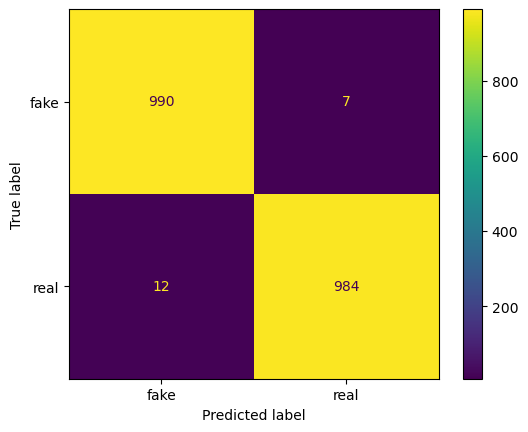

In [43]:
y_test_map = np.zeros_like(y_test2)
y_test_hat_map = np.zeros_like(y_test2)

for i in range(len(y_test2)):
    if y_test2[i] == 0:
        y_test_map[i] = 1
    if y_test_hat_ovo[i] == 0:
        y_test_hat_map[i] = 1
cm = confusion_matrix(y_test_map,y_test_hat_map)
ConfusionMatrixDisplay(cm,display_labels=["fake","real"]).plot()

## Confusion matrix for multiclass classification

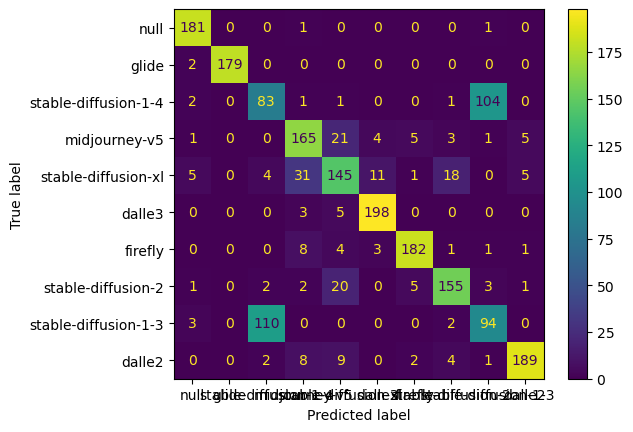

In [56]:
y_test_hat_ovo = ovo.predict(X_test)

cm = confusion_matrix(y_test,y_test_hat_ovo)
labels = ['null',
          'glide',
          'stable-diffusion-1-4',
          'midjourney-v5',
          'stable-diffusion-xl',
          'dalle3',
          'firefly',
          'stable-diffusion-2',
          'stable-diffusion-1-3',
          'dalle2']


display = ConfusionMatrixDisplay(cm,display_labels=labels)
display.plot()